In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import string

from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from adjustText import adjust_text

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from sklearn.metrics import confusion_matrix

import joblib
import plotly.figure_factory as ff
import numpy as np

In [ ]:
file_path = "data/filtered_language_detection.csv"
data = pd.read_csv(file_path)

#Calcolare il totale delle righe
total_rows = len(data)

#Calcolare la frequenza delle lingue
language_counts = data['lan_code'].value_counts()

#Filtrare i codici lingua con frequenza >= 0.01% del totale
threshold = 0.01 * total_rows  # 0.1% del totale
valid_languages = language_counts[language_counts >= threshold].index

#Filtrare il dataset mantenendo solo le righe con i codici lingua validi
filtered_data = data[data['lan_code'].isin(valid_languages)]

#Salvare il nuovo dataset in un file CSV
output_path = 'data/doublefiltered_language_detection.csv'  # Sostituisci con il nome desiderato per il file
filtered_data.to_csv(output_path, index=False)


print(f"Nuovo file CSV salvato in: {output_path}")
print(f"Dimensione del nuovo dataset: {len(filtered_data)} righe (su {total_rows} totali).")
print(f"Number of valid languages: {len(valid_languages)}")

In [ ]:
# Caricamento del dataset
file_path = "data/doublefiltered_language_detection.csv"
df = pd.read_csv(file_path, usecols=['lan_code', 'sentence'])

# Calcola il numero minimo di frasi tra le lingue
min_documents = df.groupby('lan_code').size().min()
print(f"Numero minimo di documenti per lingua: {min_documents}")

# Campiona casualmente lo stesso numero di documenti per ogni lingua
balanced_df = df.groupby('lan_code').apply(lambda x: x.sample(n=min_documents, random_state=42)).reset_index(drop=True)

# Verifica il bilanciamento
balanced_counts = balanced_df.groupby('lan_code').size()
print("Conteggio dei documenti bilanciati per lingua:")
print(balanced_counts)

# Salva il dataset bilanciato in un file CSV (opzionale)
balanced_df.to_csv("data/balanced_language_dataset.csv", index=False)

In [ ]:
# Caricare il dataset
file_path = 'data/balanced_language_dataset.csv'  # Sostituisci con il percorso del tuo file CSV
data = pd.read_csv(file_path, usecols=['lan_code', 'sentence'])

# Divisione in caratteristiche (X) e target (y)
X = data['sentence']
y = data['lan_code']

tfidf_vectorizer = TfidfVectorizer(lowercase=True)
X_tfidf = tfidf_vectorizer.fit_transform(X)

print("Vectorizer ready")

Vectorizer ready


In [14]:
X_tfidf.shape

(2098476, 833478)

# test 1

In [3]:
# Clustering su dati ridotti
num_clusters = 200
kmeans = KMeans(n_clusters=num_clusters, init="k-means++",random_state=42)
clusters = kmeans.fit_predict(X_tfidf)

# Analisi dei risultati
data['cluster'] = clusters
# Converte il risultato in DataFrame
grouped = data.groupby(['lan_code', 'cluster']).size().reset_index(name='count')

# Calcolo del totale per ciascun cluster
cluster_totals = grouped.groupby('cluster')['count'].sum().reset_index()
cluster_totals.columns = ['cluster', 'total_count']

# Unione con i dati originali per calcolare la frazione
grouped = grouped.merge(cluster_totals, on='cluster')
grouped['fraction'] = grouped['count'] / grouped['total_count']

# Calcolo della "homogeneity" stimata
homogeneity = grouped.groupby('cluster')['fraction'].max().mean()

# Risultati
print(f"Stima della Homogeneity: {homogeneity:.4f}")

grouped.to_csv("clustering_results.csv", index=False)

print("Risultato salvato in 'clustering_results.csv'.")

Stima della Homogeneity: 0.8456
Risultato salvato in 'clustering_results.csv'.


In [4]:
# Dopo aver identificato best_clusters
data['cluster'] = clusters

# Raggruppa per cluster e lingua per calcolare le conte
grouped = data.groupby(['lan_code', 'cluster']).size().reset_index(name='count')

# Calcolo del totale per ciascun cluster
cluster_totals = grouped.groupby('cluster')['count'].sum().reset_index()
cluster_totals.columns = ['cluster', 'total_count']

# Unione con i dati originali per calcolare la frazione
grouped = grouped.merge(cluster_totals, on='cluster')
grouped['fraction'] = grouped['count'] / grouped['total_count']

# Trova la lingua dominante per ciascun cluster
dominant_languages = grouped.loc[grouped.groupby('cluster')['fraction'].idxmax()][['cluster', 'lan_code', 'fraction']]

# Ordina per cluster e visualizza
dominant_languages = dominant_languages.sort_values(by='cluster')
print(dominant_languages)

# Salva i risultati in un file CSV (opzionale)
dominant_languages.to_csv("balanced_dominant_languages_per_cluster.csv", index=False)
print("I risultati delle lingue dominanti sono stati salvati in 'balanced_dominant_languages_per_cluster.csv'.")

     cluster lan_code  fraction
285        0      heb  1.000000
102        1      eng  0.999784
618        2      rus  0.544979
103        3      eng  0.872981
144        4      epo  0.992557
..       ...      ...       ...
617      195      por  1.000000
782      196      ukr  0.995253
301      197      heb  1.000000
235      198      fin  0.833558
101      199      deu  0.999687

[200 rows x 3 columns]
I risultati delle lingue dominanti sono stati salvati in 'balanced_dominant_languages_per_cluster.csv'.


C:\Users\saver\AppData\Local\Temp\ipykernel_13708\2787930670.py:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\saver\AppData\Local\Temp\ipykernel_13708\2787930670.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
C:\Users\saver\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


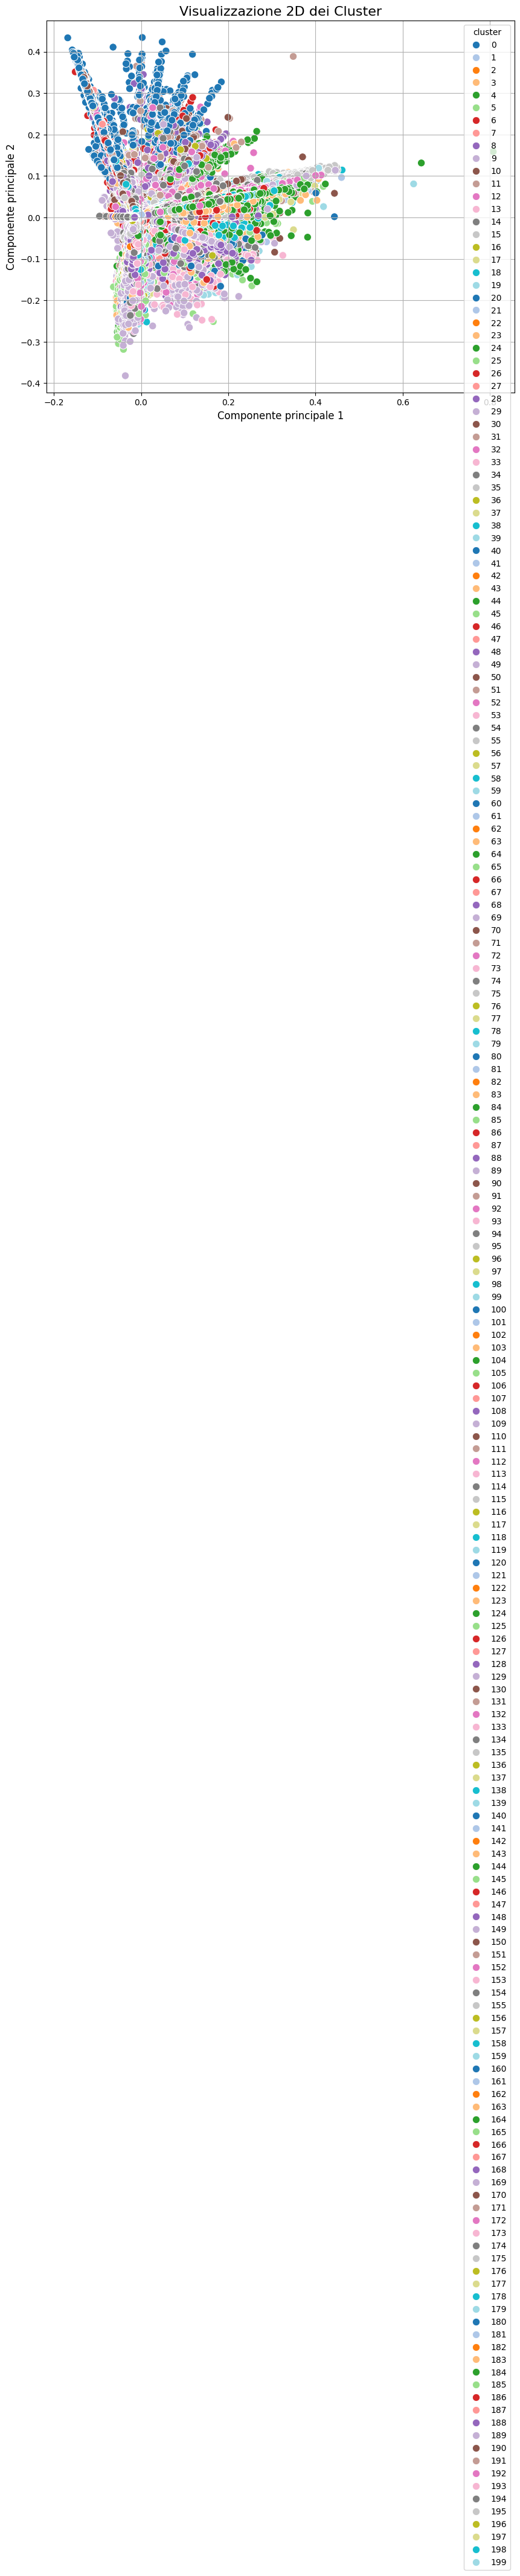

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

# Riduci la dimensionalità con PCA (o puoi usare t-SNE, UMAP, etc.)
pca = PCA(n_components=2, random_state=42)

reduced_matrix_2d = pca.fit_transform(X_tfidf)

# Visualizza i punti nel piano 2D, colorati per cluster
plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced_matrix_2d[:, 0], y=reduced_matrix_2d[:, 1], hue=data['cluster'], palette="tab20", s=80, marker='o')

# Aggiungi titolo e etichette
plt.title('Visualizzazione 2D dei Cluster', fontsize=16)
plt.xlabel('Componente principale 1', fontsize=12)
plt.ylabel('Componente principale 2', fontsize=12)
plt.grid(True)

# Mostra il grafico
plt.tight_layout()
plt.show()

In [6]:
# Ora associamo a ciascun cluster la lingua dominante
cluster_to_language = {}
for cluster in data['cluster'].unique():
    # Trova la lingua prevalente per ciascun cluster
    most_common_language = data[data['cluster'] == cluster]['lan_code'].mode()[0]
    cluster_to_language[cluster] = most_common_language

print(cluster_to_language)

{188: 'jpn', 11: 'ber', 88: 'ber', 59: 'ber', 117: 'ber', 6: 'kab', 114: 'ber', 192: 'ber', 115: 'kab', 136: 'ber', 140: 'kab', 52: 'ber', 169: 'nld', 150: 'ber', 67: 'kab', 24: 'ber', 171: 'ber', 100: 'eng', 172: 'ber', 84: 'eng', 3: 'eng', 139: 'nld', 25: 'kab', 14: 'kab', 7: 'nld', 110: 'kab', 44: 'tur', 65: 'ita', 181: 'ita', 182: 'eng', 129: 'epo', 50: 'ber', 89: 'epo', 15: 'tur', 43: 'epo', 193: 'kab', 164: 'spa', 70: 'kab', 83: 'epo', 145: 'ita', 17: 'deu', 54: 'spa', 175: 'hun', 13: 'por', 20: 'fra', 157: 'epo', 167: 'spa', 176: 'fra', 61: 'deu', 174: 'spa', 78: 'eng', 119: 'por', 79: 'pol', 53: 'deu', 199: 'deu', 170: 'deu', 149: 'deu', 18: 'deu', 155: 'deu', 30: 'deu', 183: 'deu', 8: 'deu', 141: 'deu', 122: 'deu', 161: 'deu', 68: 'deu', 148: 'deu', 96: 'deu', 143: 'ita', 39: 'pol', 123: 'spa', 103: 'eng', 85: 'epo', 111: 'fin', 180: 'ita', 128: 'epo', 159: 'por', 16: 'fra', 91: 'fra', 46: 'spa', 179: 'eng', 116: 'ita', 1: 'eng', 94: 'eng', 166: 'eng', 58: 'tur', 12: 'eng', 81

In [7]:
def predict_languages_for_phrases(phrases, vectorizer, kmeans):
    """
    Prevede le lingue per un batch di frasi.
    """
    # Trasforma le frasi in vettori
    vectors = vectorizer.transform(phrases)

    # Prevede i cluster per le frasi
    predicted_clusters = kmeans.predict(vectors)

    # Recupera le lingue associate ai cluster
    predicted_languages = [cluster_to_language[cluster] for cluster in predicted_clusters]
    return predicted_languages

In [ ]:
import csv
import random

accuracy = 0
n_rows = 0
sample_fraction = 0.2  # Percentuale di righe da utilizzare

# Carica le frasi e i codici lingua
with open('data/balanced_language_dataset.csv', encoding='utf-8') as csvfile:
    reader = list(csv.DictReader(csvfile))  # Converte il reader in una lista
    sampled_rows = random.sample(reader, int(len(reader) * sample_fraction))  # Campionamento

# Prepara batch di frasi e codici reali
sentences = [row['sentence'] for row in sampled_rows]
real_lan_codes = [row['lan_code'] for row in sampled_rows]

# Prevede le lingue per le frasi campionate
predicted_languages = predict_languages_for_phrases(sentences, tfidf_vectorizer, kmeans)

# Calcola l'accuratezza
for real, predicted in zip(real_lan_codes, predicted_languages):
    n_rows += 1
    if real == predicted:
        accuracy += 1

accuracy_percentage = (accuracy / n_rows) * 100 if n_rows > 0 else 0
print(f"Accuracy: {accuracy_percentage:.2f}%")

Accuracy: 59.40%
